# 1. Loading in the Dataset

In [1]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/fruits_dataset.tar.gz
import tarfile

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=output_path)

extract_tar_gz('/content/fruits_dataset.tar.gz', '/content')

--2023-07-27 17:18:17--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/fruits_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.217.236.153, 52.216.216.209, 52.217.97.116, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.217.236.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 361408056 (345M) [application/x-gzip]
Saving to: ‘fruits_dataset.tar.gz’

fruits_dataset.tar. 100%[===================>] 344.67M  32.6MB/s    in 11s     

2023-07-27 17:18:28 (30.5 MB/s) - ‘fruits_dataset.tar.gz’ saved [361408056/361408056]



In [2]:
import tensorflow as tf
from tensorflow.keras import layers

train_set = tf.keras.utils.image_dataset_from_directory(
    directory='fruits/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=256,
    image_size=(100, 100),
    validation_split=0.25,
    subset="training",
    seed=417)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory='fruits/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=256,
    image_size=(100, 100),
    validation_split=0.25,
    subset="validation",
    seed=417)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory='fruits/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=256,
    image_size=(100, 100))

normalization_layer = layers.Rescaling(1/255)

train_set_normalized = train_set.map(lambda x, y: (normalization_layer(x), y))
validation_set_normalized = validation_set.map(lambda x, y: (normalization_layer(x), y))
test_set_normalized = test_set.map(lambda x, y: (normalization_layer(x), y))

Found 67692 files belonging to 131 classes.
Using 50769 files for training.
Found 67692 files belonging to 131 classes.
Using 16923 files for validation.
Found 22688 files belonging to 131 classes.


# 2. Loading in a Pre-Trained Model

In [3]:
from tensorflow.keras import applications

base_model = applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(100, 100, 3))

94765736/94765736 [==============================] - 3s 0us/step


# 3. Training the Model

In [4]:
from tensorflow.keras import Model, Input

base_model.trainable = False

input_layer = Input(shape=(100, 100, 3))
features_layer = base_model(input_layer, training=False)
global_pooling = layers.GlobalAveragePooling2D()(features_layer)
output = layers.Dense(131)(global_pooling)

model = Model(inputs=input_layer, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 131)               268419    
                                                                 
Total params: 23,856,131
Trainable params: 268,419
Non-trainable params: 23,587,712
_________________________________________________________________


In [5]:
opt = tf.keras.optimizers.SGD()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

model.fit(train_set_normalized, epochs=3, validation_data=validation_set_normalized)

Epoch 1/3
199/199 [==============================] - 66s 258ms/step - loss: 4.8567 - accuracy: 0.0121 - val_loss: 4.8149 - val_accuracy: 0.0207
Epoch 2/3
199/199 [==============================] - 58s 291ms/step - loss: 4.7903 - accuracy: 0.0176 - val_loss: 4.7661 - val_accuracy: 0.0249
Epoch 3/3
199/199 [==============================] - 50s 249ms/step - loss: 4.7429 - accuracy: 0.0270 - val_loss: 4.7201 - val_accuracy: 0.0232


# 4. Preprocessing the Input

In [6]:
input_layer = Input(shape=(100, 100, 3))
preprocessed_input_layer = applications.resnet50.preprocess_input(input_layer)
features_layer = base_model(preprocessed_input_layer, training=False)
global_pooling = layers.GlobalAveragePooling2D()(features_layer)
output = layers.Dense(131)(global_pooling)

model = Model(inputs=input_layer, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 100, 100, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 131)               2684

In [7]:
opt = tf.keras.optimizers.SGD()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

model.fit(train_set, epochs=3, validation_data=validation_set)

test_loss, test_acc = model.evaluate(test_set)
print(f"Test set accuracy: {test_acc}")

Epoch 1/3
199/199 [==============================] - 54s 256ms/step - loss: 2.0554 - accuracy: 0.6267 - val_loss: 0.7951 - val_accuracy: 0.8991
Epoch 2/3
199/199 [==============================] - 50s 246ms/step - loss: 0.5424 - accuracy: 0.9454 - val_loss: 0.4077 - val_accuracy: 0.9570
Epoch 3/3
89/89 [==============================] - 18s 200ms/step - loss: 0.4979 - accuracy: 0.9118
Test set accuracy: 0.9117594957351685


# 5. Fine-tuning the Model

In [ ]:
base_model.trainable = True

opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

model.fit(train_set, epochs=5, validation_data=validation_set)

test_loss, test_acc = model.evaluate(test_set)
print(f"Test set accuracy: {test_acc}")

Epoch 1/5
199/199 [==============================] - 44s 126ms/step - loss: 0.1591 - accuracy: 0.9809 - val_loss: 0.1253 - val_accuracy: 0.9804
Epoch 2/5
199/199 [==============================] - 23s 115ms/step - loss: 0.1002 - accuracy: 0.9855 - val_loss: 0.0914 - val_accuracy: 0.9851
Epoch 3/5
199/199 [==============================] - 23s 115ms/step - loss: 0.0750 - accuracy: 0.9894 - val_loss: 0.0717 - val_accuracy: 0.9882
Epoch 4/5
199/199 [==============================] - 23s 115ms/step - loss: 0.0592 - accuracy: 0.9924 - val_loss: 0.0583 - val_accuracy: 0.9914
Epoch 5/5
89/89 [==============================] - 3s 33ms/step - loss: 0.2519 - accuracy: 0.9293
Test set accuracy: 0.9293459057807922


# 6. Transfer Learning on the Beans Dataset I

In [10]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/beans_dataset.tar.gz

--2023-07-27 17:37:34--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/beans_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 3.5.3.22, 3.5.28.243, 16.182.39.121, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|3.5.3.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179790562 (171M) [application/x-gzip]
Saving to: ‘beans_dataset.tar.gz’

beans_dataset.tar.g 100%[===================>] 171.46M  32.2MB/s    in 6.0s    

2023-07-27 17:37:41 (28.7 MB/s) - ‘beans_dataset.tar.gz’ saved [179790562/179790562]



In [11]:
extract_tar_gz('/content/beans_dataset.tar.gz', '/content')

b_train_set = tf.keras.utils.image_dataset_from_directory(
    directory='beans/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(100, 100))

b_validation_set = tf.keras.utils.image_dataset_from_directory(
    directory='beans/validation/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(100, 100))

b_test_set = tf.keras.utils.image_dataset_from_directory(
    directory='beans/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(100, 100))

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


Epoch 1/20
9/9 [==============================] - 11s 367ms/step - loss: 1.1506 - accuracy: 0.5039 - val_loss: 0.8892 - val_accuracy: 0.6241
Epoch 2/20
9/9 [==============================] - 3s 144ms/step - loss: 0.7695 - accuracy: 0.6702 - val_loss: 0.6893 - val_accuracy: 0.7293
Epoch 3/20
9/9 [==============================] - 5s 141ms/step - loss: 0.6133 - accuracy: 0.7447 - val_loss: 0.5963 - val_accuracy: 0.7744
Epoch 4/20
9/9 [==============================] - 3s 142ms/step - loss: 0.5453 - accuracy: 0.7718 - val_loss: 0.5366 - val_accuracy: 0.7970
Epoch 5/20
9/9 [==============================] - 3s 144ms/step - loss: 0.4799 - accuracy: 0.8104 - val_loss: 0.5104 - val_accuracy: 0.7970
Epoch 6/20
9/9 [==============================] - 4s 253ms/step - loss: 0.4648 - accuracy: 0.8075 - val_loss: 0.4744 - val_accuracy: 0.8271
Epoch 7/20
9/9 [==============================] - 3s 143ms/step - loss: 0.4289 - accuracy: 0.8366 - val_loss: 0.4477 - val_accuracy: 0.8571
Epoch 8/20
9/9 [===

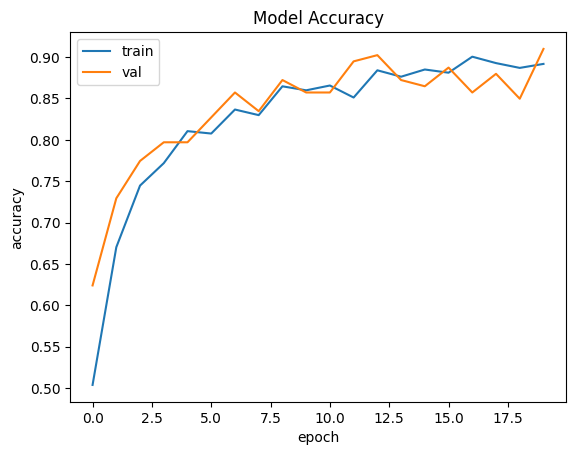

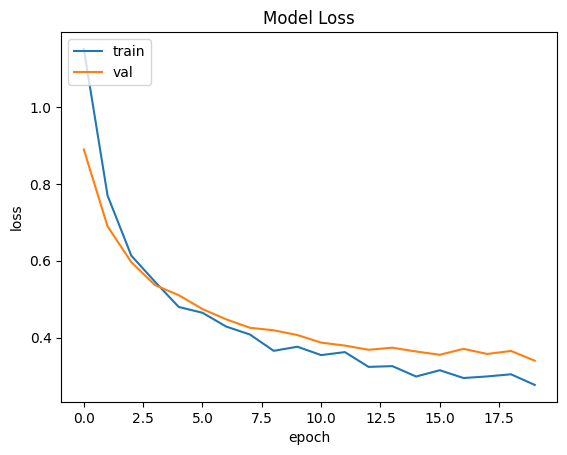

In [12]:
base_model = applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(100, 100, 3))

base_model.trainable = False

input_layer = Input(shape=(100, 100, 3))
preprocessed_input_layer = applications.resnet50.preprocess_input(input_layer)
augmentation_layer = layers.RandomFlip(mode="horizontal_and_vertical")(preprocessed_input_layer)
features_layer = base_model(augmentation_layer, training=False)
global_pooling = layers.GlobalAveragePooling2D()(features_layer)
output = layers.Dense(3)(global_pooling)

model = Model(inputs=input_layer, outputs=output)

opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history = model.fit(b_train_set, epochs=20, validation_data=b_validation_set)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 7. Transfer Learning on the Beans Dataset II

In [13]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history = model.fit(b_train_set, epochs=5, validation_data=b_validation_set)

test_loss, test_acc = model.evaluate(b_test_set)
print(f"Test set accuracy: {test_acc}")

Epoch 1/5
9/9 [==============================] - 14s 290ms/step - loss: 0.2665 - accuracy: 0.9043 - val_loss: 0.3489 - val_accuracy: 0.8647
Epoch 2/5
9/9 [==============================] - 4s 261ms/step - loss: 0.2600 - accuracy: 0.9043 - val_loss: 0.3317 - val_accuracy: 0.9023
Epoch 3/5
9/9 [==============================] - 4s 150ms/step - loss: 0.2457 - accuracy: 0.9217 - val_loss: 0.3377 - val_accuracy: 0.9023
Epoch 4/5
9/9 [==============================] - 4s 153ms/step - loss: 0.2324 - accuracy: 0.9207 - val_loss: 0.3288 - val_accuracy: 0.9023
Epoch 5/5
1/1 [==============================] - 0s 400ms/step - loss: 0.3067 - accuracy: 0.8906
Test set accuracy: 0.890625
